In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os

%matplotlib notebook
#%matplotlib inline

from ipywidgets import interact #, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def rename_string_to_label(string):
    return(string.replace('b-pulseAlongX_0.22','UV').replace('z-from_S1_without_pulse','FC_1').replace('m-only_IR_longer_with_nac_2_1','IR_long').replace('_0000',''))

In [3]:
fol = '/home/alessio/k-nokick/'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir not in ['HTML','csv']])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> IMPORTANTS
1 -> a-restart_b-pulseAlongX_0.22_0000
2 -> b-pulseAlongX_0.22_goodG_0000
3 -> b-pulseAlongX_0.22_short_0_goodG_0000
4 -> b-pulseAlongX_0.22_short_pi_goodG_0000
5 -> m-only_IR_longer_with_nac_2_1_0000
6 -> m-only_IR_longer_with_nac_2_1_counterClock_0000
7 -> m-only_IR_longer_with_nac_2_1_inverted_phase_0000
8 -> m-only_IR_longer_with_nac_2_1_phase_pi_0000
9 -> m-only_IR_short_with_nac_2_1_0000
10 -> m-only_IR_short_with_nac_2_1_inverted_phase_0000
11 -> m-only_IR_short_with_nac_2_1_phase_pi_0000
12 -> z-from_S1_without_pulse_0000
13 -> z-from_S2_without_pulse_0000



In [89]:
def create_df_from_files_given_name(name,fol,fs_end_pulse):
    '''
    This creates the excel file from the 4 files
    '''
    project_folder = os.path.join(fol,name)
    
    output_norm = os.path.join(project_folder, 'output')
    output_popu = os.path.join(project_folder, 'outputPopul')
    output_abso = os.path.join(project_folder, 'Output_Abs')
    output_regi = os.path.join(project_folder, 'Output_Regions')
    
    df_norm2 = pd.read_csv(output_norm, delim_whitespace=True, index_col=0, names=['counter', 'steps', 'fs','Norm deviation','Kinetic','Potential','Total','Total Deviation','Xpulse','Ypulse','Zpulse'])
    df_popu2 = pd.read_csv(output_popu, delim_whitespace=True, names=['fs', 'S0', 'S1','S2','S3','S4','S5','S6','S7'])
    df_abso2 = pd.read_csv(output_abso, delim_whitespace=True, names=['Time AU', 'Abs Tot', 'Abs S0', 'Abs S1','Abs S2','Abs S3','Abs S4','Abs S5','Abs S6','Abs S7'])
    df_regi2 = pd.read_csv(output_regi, delim_whitespace=True, names=['FC','Reactants','Products'])
    

    # I need to cut down to different file size <- this will become obsolete
    dfs = [df_norm2,df_popu2,df_abso2,df_regi2]
    lengths = min([x.shape[0] for x in dfs])
    print('I will cut down to {}'.format(lengths))
    df_norm, df_popu, df_abso, df_regi = [ x.drop(x.index[lengths:]) for x in dfs ]
    
    AU_dt = df_abso['Time AU'].iloc[1]
    
    df_abso['Norm Tot'] = df_abso['Abs Tot'] / AU_dt
    df_abso['Norm S0'] = df_abso['Abs S0'] / AU_dt 
    df_abso['Norm S1'] = df_abso['Abs S1'] / AU_dt 
    df_abso['Norm S2'] = df_abso['Abs S2'] / AU_dt 
    df_abso['Norm S3'] = df_abso['Abs S3'] / AU_dt 
    df_abso['Norm S4'] = df_abso['Abs S4'] / AU_dt 
    df_abso['Norm S5'] = df_abso['Abs S5'] / AU_dt 
    df_abso['Norm S6'] = df_abso['Abs S6'] / AU_dt 
    df_abso['Norm S7'] = df_abso['Abs S7'] / AU_dt
    
    #fs_end_pulse = 15 # this is where I start to count Fc population retourning in S0 after the pulse.
    fs_array = df_norm2['fs']
    filtering_on_indexes = np.arange(lengths)
    number_line_after_pulse = np.where(fs_array > fs_end_pulse)[0][0]
    
    fs_after_pulse = df_popu['fs'].iloc[number_line_after_pulse]
    s1_after_pulse = df_popu['S1'].iloc[number_line_after_pulse]
    print('At time {}, after pulse, population in S1 is: {}'.format(fs_after_pulse,s1_after_pulse))
    
    if number_line_after_pulse != 0:
        value_to_subtract = df_regi['FC'].iloc[number_line_after_pulse-1]
        df_regi['FC after pulse'] = np.where( filtering_on_indexes < number_line_after_pulse, 0, (df_regi['FC']-value_to_subtract))
    else:
        df_regi['FC after pulse'] = df_regi['FC']
        
    df_regi['Real Reactants'] = df_regi['Reactants'] + df_regi['FC after pulse']
    df_regi['Real Products'] = df_regi['Products'] + df_abso['Norm S0']
    
    df_all = pd.concat([df_norm,df_popu,df_abso,df_regi],axis=1)
    
    csv_name = '{}.csv'.format(project_folder)
    print('saving file {}'.format(csv_name))
    
    df_all.to_csv(csv_name)
    
    df_all['ratio'] = df_all['Products']/df_all['Reactants']
    df_all['Real ratio'] = df_all['Real Products']/df_all['Real Reactants']
    
    #df_all.plot('fs',['Reactants','Products'])
    #df_all.plot('fs','ratio')
    #df_all.plot('fs',['Real Reactants','Real Products'])
    
    return(df_all[['fs','ratio','Real Products','Real Reactants','Norm S0', 'Products', 'Reactants','Real ratio','S1']])

number = 3

a = create_df_from_files_given_name('z-from_S1_without_pulse_0000',fol,0)
b = create_df_from_files_given_name('b-pulseAlongX_0.22_goodG_0000',fol,15)
c = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_0000',fol,15)
d = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_counterClock_0000',fol,15)
e = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_inverted_phase_0000',fol,15)
f = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_phase_pi_0000',fol,15)

I will cut down to 2001
At time 0.1001, after pulse, population in S1 is: 0.999999
saving file /home/alessio/k-nokick/z-from_S1_without_pulse_0000.csv
I will cut down to 3282
At time 15.015, after pulse, population in S1 is: 0.523371
saving file /home/alessio/k-nokick/b-pulseAlongX_0.22_goodG_0000.csv
I will cut down to 4001
At time 15.015, after pulse, population in S1 is: 0.0748783
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_0000.csv
I will cut down to 4001
At time 15.015, after pulse, population in S1 is: 0.07246439999999998
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_counterClock_0000.csv
I will cut down to 4001
At time 15.015, after pulse, population in S1 is: 0.0913654
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_inverted_phase_0000.csv
I will cut down to 4001
At time 15.015, after pulse, population in S1 is: 0.0767448
saving file /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_phase_pi_0000.csv


In [90]:
title1 = 'Products vs Reactants'
title2 = 'Ratio: Products/Reactants'
title3 = 'Absorbed at each time'
title4 = 'Total absorbed'

<IPython.core.display.Javascript object>


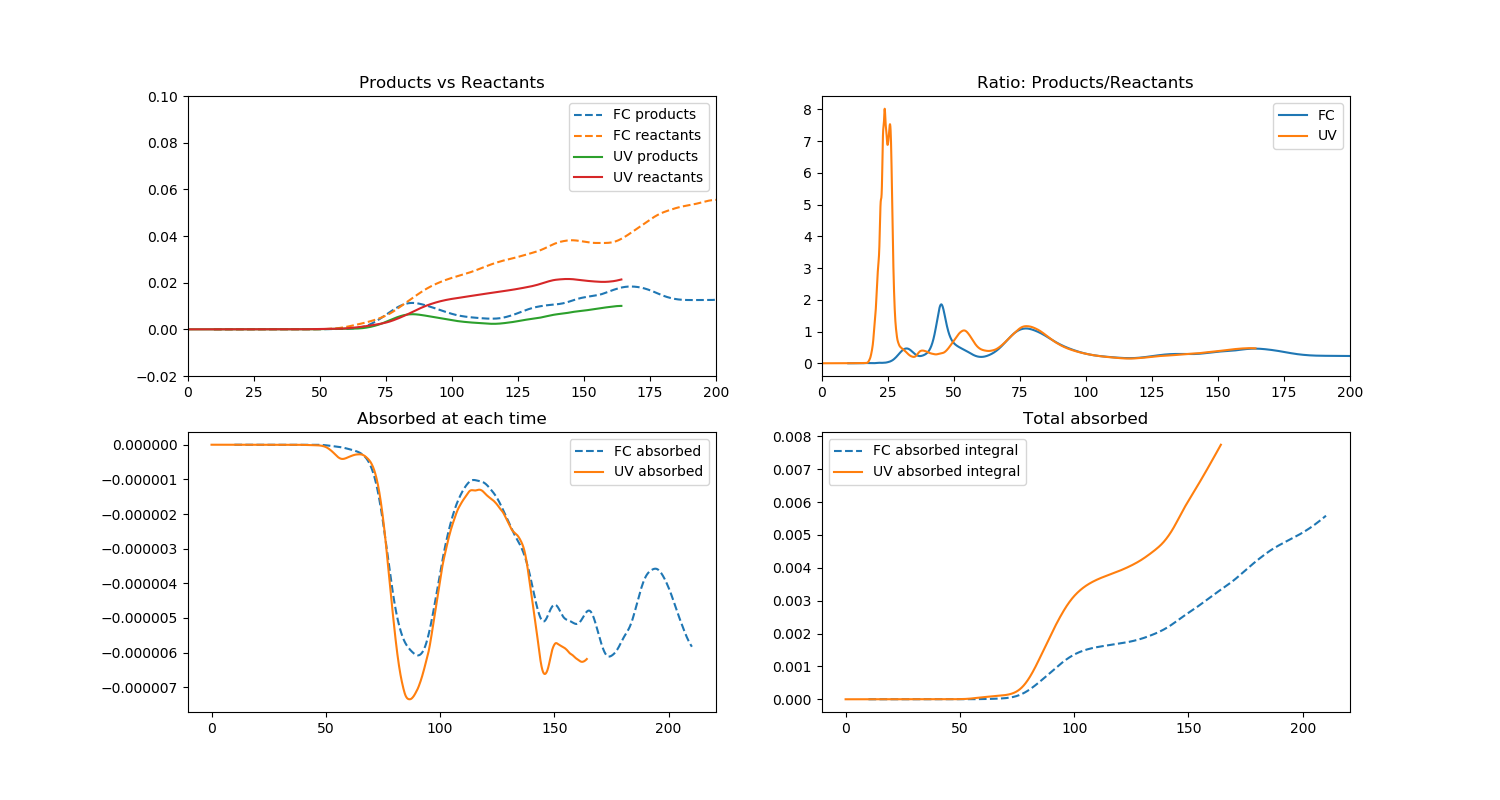

In [91]:
fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(15,8))

normG = 1
#normG = 0.523

ax0.plot(a['fs'].iloc[:,1]+10,  a['Products'], label='FC products',ls='--')
ax0.plot(a['fs'].iloc[:,1]+10,  a['Reactants'], label='FC reactants',ls='--')
ax0.plot(b['fs'].iloc[:,1],     b['Products']/normG, label='UV products')
ax0.plot(b['fs'].iloc[:,1],     b['Reactants']/normG, label='UV reactants')
ax0.set_title(title1)
ax0.set_xlim(0,200)
ax0.set_ylim(-0.02,0.1)
ax0.legend()

ax1.plot(a['fs'].iloc[:,1]+10,  a['ratio'], label='FC')
ax1.plot(b['fs'].iloc[:,1],     b['ratio'], label='UV')
ax1.set_xlim(0,200)
ax1.set_title(title2)
ax1.legend()

ax2.plot(a['fs'].iloc[:,1]+10, a['Norm S0'], label='FC absorbed', ls='--')
ax2.plot(b['fs'].iloc[:,1],    b['Norm S0']/normG, label='UV absorbed')
ax2.set_title(title3)
ax2.legend()

ax3.plot(a['fs'].iloc[:,1]+10, -np.cumsum(a['Norm S0']), label='FC absorbed integral', ls='--')
ax3.plot(b['fs'].iloc[:,1],    -np.cumsum(b['Norm S0']/normG), label='UV absorbed integral')
ax3.set_title(title4)
ax3.legend()

# IR ones

<IPython.core.display.Javascript object>


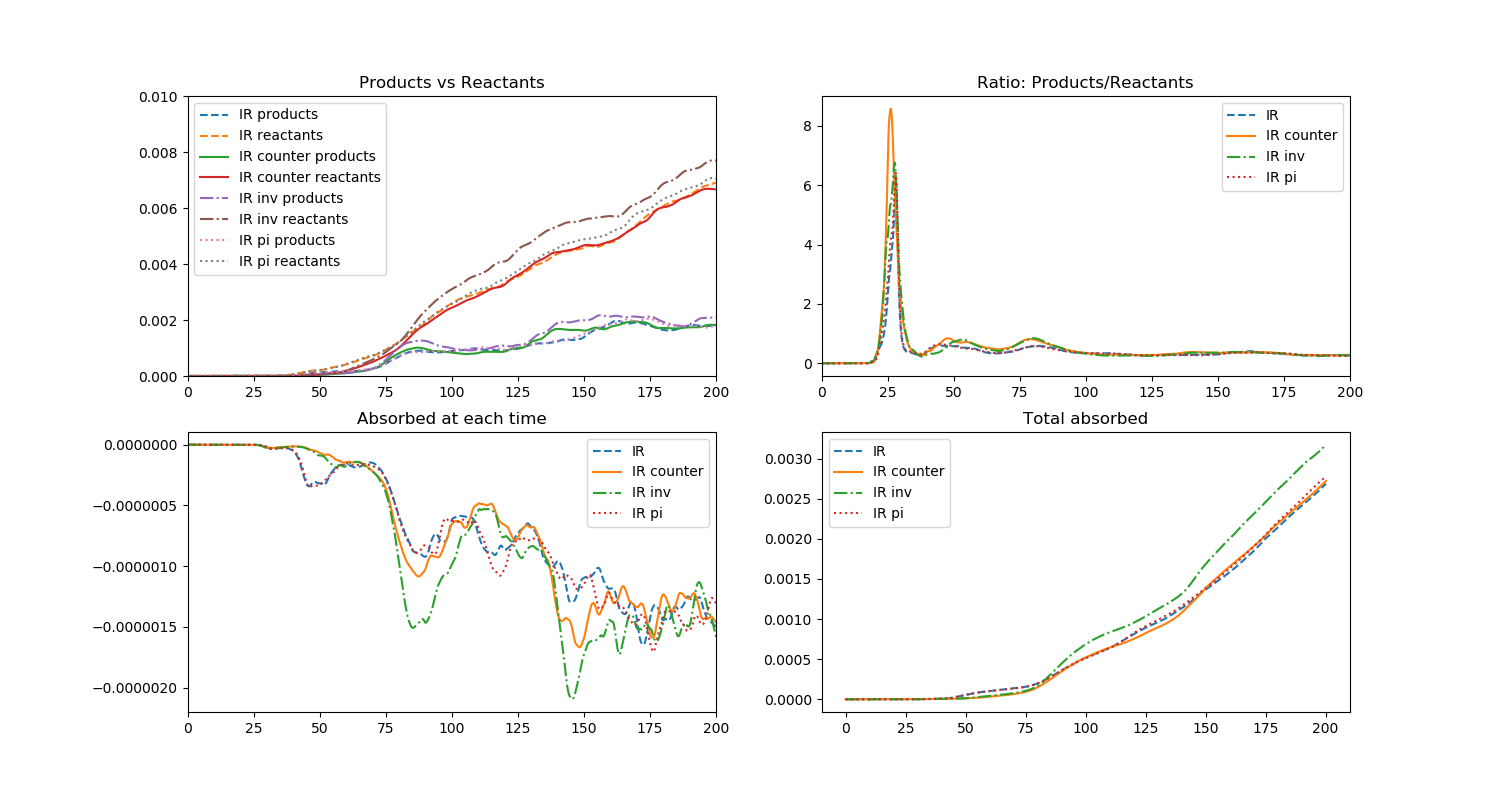

In [92]:
fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(15,8))

normG = 1
#normG = 0.523

ax0.plot(c['fs'].iloc[:,1],  c['Products'], label='IR products',ls='--')
ax0.plot(c['fs'].iloc[:,1],  c['Reactants'], label='IR reactants',ls='--')
ax0.plot(d['fs'].iloc[:,1],  d['Products'], label='IR counter products')
ax0.plot(d['fs'].iloc[:,1],  d['Reactants'], label='IR counter reactants')
ax0.plot(e['fs'].iloc[:,1],  e['Products'], label='IR inv products',ls='-.')
ax0.plot(e['fs'].iloc[:,1],  e['Reactants'], label='IR inv reactants',ls='-.')
ax0.plot(f['fs'].iloc[:,1],  f['Products'], label='IR pi products',ls=':')
ax0.plot(f['fs'].iloc[:,1],  f['Reactants'], label='IR pi reactants',ls=':')
ax0.set_title(title1)
ax0.set_xlim(0,200)
ax0.set_ylim(0,0.01)
ax0.legend()

ax1.plot(c['fs'].iloc[:,1],     c['ratio'], label='IR',ls='--')
ax1.plot(d['fs'].iloc[:,1],     d['ratio'], label='IR counter')
ax1.plot(e['fs'].iloc[:,1],     e['ratio'], label='IR inv',ls='-.')
ax1.plot(f['fs'].iloc[:,1],     f['ratio'], label='IR pi',ls=':')
ax1.set_title(title2)
ax1.set_xlim(0,200)
ax1.legend()

ax2.plot(c['fs'].iloc[:,1],     c['Norm S0'], label='IR',ls='--')
ax2.plot(d['fs'].iloc[:,1],     d['Norm S0'], label='IR counter')
ax2.plot(e['fs'].iloc[:,1],     e['Norm S0'], label='IR inv',ls='-.')
ax2.plot(f['fs'].iloc[:,1],     f['Norm S0'], label='IR pi',ls=':')
ax2.set_title(title3)
ax2.set_xlim(0,200)
ax2.legend()

ax3.plot(c['fs'].iloc[:,1],     -np.cumsum(c['Norm S0']), label='IR',ls='--')
ax3.plot(d['fs'].iloc[:,1],     -np.cumsum(d['Norm S0']), label='IR counter')
ax3.plot(e['fs'].iloc[:,1],     -np.cumsum(e['Norm S0']), label='IR inv',ls='-.')
ax3.plot(f['fs'].iloc[:,1],     -np.cumsum(f['Norm S0']), label='IR pi',ls=':')
ax3.set_title(title4)
ax3.legend();

<IPython.core.display.Javascript object>


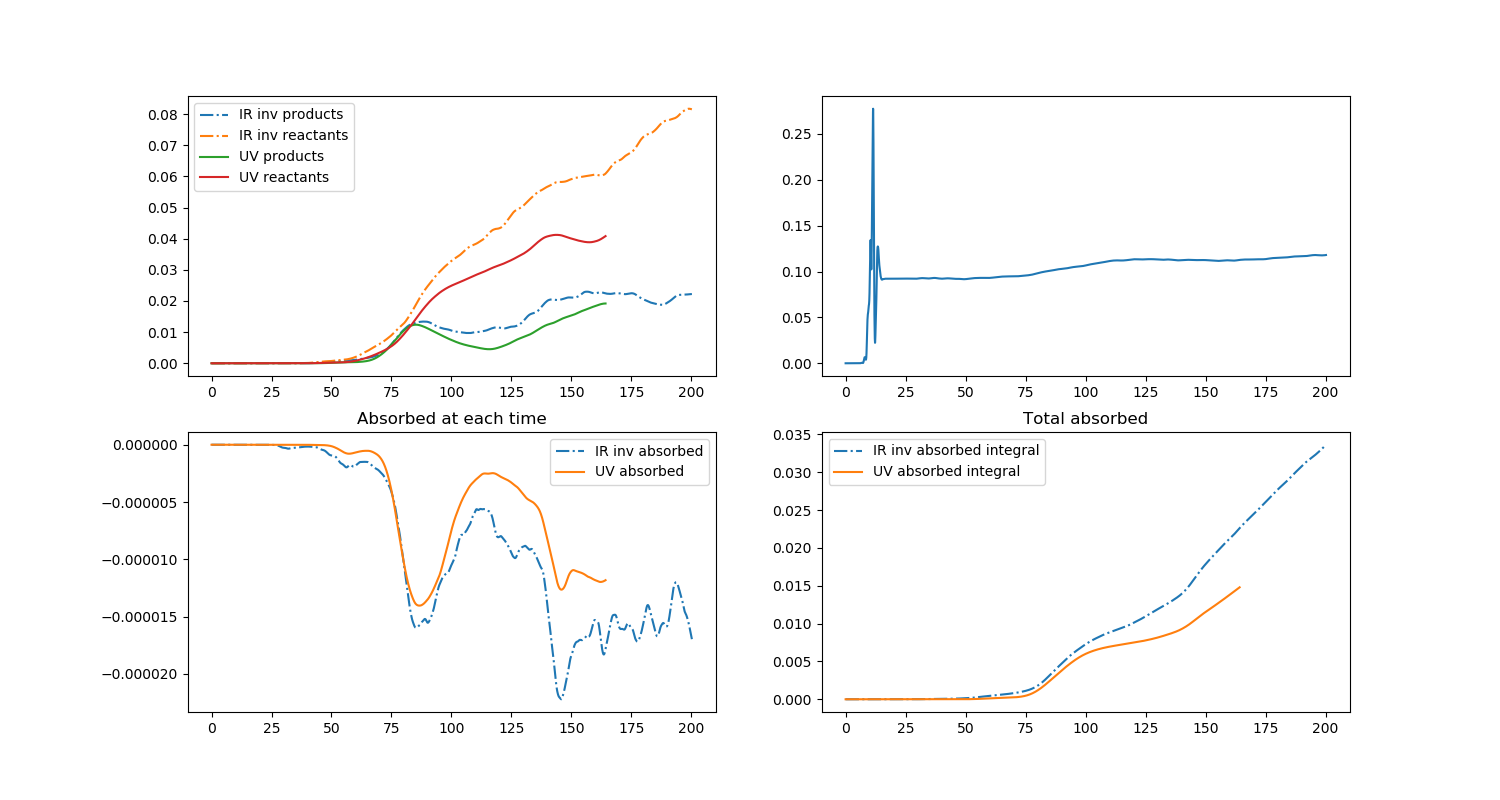

In [94]:
fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(15,8))

normUV = 0.523371
normIR = 0.0943654

#normUV = 1
#normIR = 1

ax0.plot(e['fs'].iloc[:,1],     e['Products']/normIR, label='IR inv products',ls='-.')
ax0.plot(e['fs'].iloc[:,1],     e['Reactants']/normIR, label='IR inv reactants',ls='-.')
ax0.plot(b['fs'].iloc[:,1],     b['Products']/normUV, label='UV products')
ax0.plot(b['fs'].iloc[:,1],     b['Reactants']/normUV, label='UV reactants')
ax0.legend()

ax1.plot(e['fs'].iloc[:,1], e['S1'])

ax2.plot(e['fs'].iloc[:,1],     e['Norm S0']/normIR, label='IR inv absorbed',ls='-.')
ax2.plot(b['fs'].iloc[:,1],     b['Norm S0']/normUV, label='UV absorbed')
ax2.set_title(title3)
ax2.legend()


ax3.plot(e['fs'].iloc[:,1],     -np.cumsum(e['Norm S0']/normIR), label='IR inv absorbed integral',ls='-.')
ax3.plot(b['fs'].iloc[:,1],     -np.cumsum(b['Norm S0']/normUV), label='UV absorbed integral')
ax3.set_title(title4)
ax3.legend();